#### Importing library

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import pickle

import nltk

from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import re
import distance

from scipy.sparse import hstack
from scipy import sparse
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis


C:\Users\rupes\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv(r"D:\applied\real_world_project\quora\train.csv")
print("Number of data points:",df.shape[0])
df.head(4)


Number of data points: 404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0


In [3]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

we have total 3 null values 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
#checking for null values 
df[df.isnull().any(axis=1)==True]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [6]:
# Drop the row with NaN value 
df.dropna(axis=0,inplace=True)
df.shape[0]

404287

Percentage of question are duplicate is  36.92 %
Percentage of question not duplicate is  63.08 %
Wall time: 142 ms


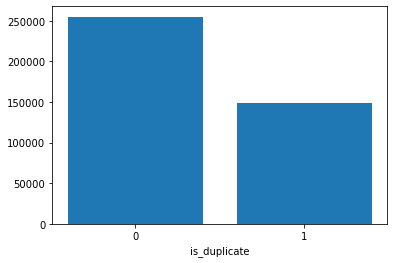

In [7]:
%%time
#checking data is balance or imbalance 
plt.bar(x=['0','1'],height=[len(df[df['is_duplicate']==0]),len(df[df['is_duplicate']==1])])
# df.is_duplicate.plot.bar()
plt.xlabel('is_duplicate')
print('Percentage of question are duplicate is ',round(len(df[df['is_duplicate']==1])/len(df)*100,2),'%')
print('Percentage of question not duplicate is ',round(len(df[df['is_duplicate']==0])/len(df)*100,2),'%')


In [17]:
# total number of unique questions 
print("Total number of unique question ",len((pd.Series(df['qid1'].tolist()+df['qid2'].tolist())).unique()))
print("Total number of unique question 1st column ",len((pd.Series(df['qid1'].tolist())).unique()))
print("Total number of unique question 2nd column ",len((pd.Series(df['qid2'].tolist())).unique()))

Total number of unique question  537929
Total number of unique question 1st column  290652
Total number of unique question 2nd column  299362


#  Simple Feature Extraction

 - ____freq_qid1____ = Number of time qid1 ouccurs Frequency of qid1's 
 - ____freq_qid2____ = Number of time qid2 ouccurs Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [12]:
#nmber of time a question ouccur in qid1 
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 

#nmber of time a question ouccur in qid2 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')


#counting the total number of letters as space also
df['q1len'] = df['question1'].str.len() 

df['q2len'] = df['question2'].str.len()

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))

df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))


def word_Common(row):
    # we are mapping lamda funtion with list of  row['question1'].split(" ")
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)
df['word_Common'] = df.apply(word_Common, axis=1)

def word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))
df['word_Total'] = df.apply(word_Total, axis=1)

def word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(word_share, axis=1)




df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,23,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,20,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,19,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


# Preprocessing of questions

In [13]:
nltk.download('stopwords')
STOP_WORDS = stopwords.words("english")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rupes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:

def preprocess(x):
    x = str(x).lower()
    #replacing the short for to full form 
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
   
    # replacing 000000 with m and 000 with k    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    #reducing a word to its word stem
    porter = PorterStemmer()
    # selecting non-alphanumeric character
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        #stemming
        x = porter.stem(x)
        
        # removing HTML tags
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

# Advance Feature Extraction

- ____freq_qid1____
-  __cwc_min__      
-   __cwc_max__       
-  __csc_min__       
- __csc_max__      
- __ctc_min__       
- __ctc_max__       
- __last_word_eq__  
- __first_word_eq__ 
- __abs_len_diff__  
- __mean_len__ 

# Fuzzy Features
- __token_set_ratio__
- __token_sort_ratio__
- __fuzz_ratio__
- __fuzz_partial_ratio__
- __longest_substr_ratio__

In [14]:
def get_token_features(q1, q2):
    
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words))+000.1)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words))+000.1)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops))+000.1)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) +000.1)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens))+000.1)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens))+000.1)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features




In [16]:
# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [17]:
def extract_features(df):
    # preprocessing each question
    # preprocress funtion defined above
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    
    
    
    
    
   
    #Computing Fuzzy Features and Merging with Dataset

    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [18]:
# extracting the feature 
df = extract_features(df)
df.head(2)

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.780142,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.463576,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [20]:
# now saving the dataframe to csv file 
df.to_csv("features_train.csv")


In [3]:
#loading the data feature_train.csv that i have saved
df_train=pd.read_csv("features_train.csv")
print(df_train.shape)
df_train.head(2)

(404287, 33)


,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,...,0.780142,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,...,0.463576,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [5]:
# now again checking null values but now i am getting 18 null values in question1 and question2 feature 
df_train.dropna(inplace=True)
df_train.isnull().sum()

Unnamed: 0              0
id                      0
qid1                    0
qid2                    0
question1               0
question2               0
is_duplicate            0
freq_qid1               0
freq_qid2               0
q1len                   0
q2len                   0
q1_n_words              0
q2_n_words              0
word_Common             0
word_Total              0
word_share              0
freq_q1+q2              0
freq_q1-q2              0
cwc_min                 0
cwc_max                 0
csc_min                 0
csc_max                 0
ctc_min                 0
ctc_max                 0
last_word_eq            0
first_word_eq           0
abs_len_diff            0
mean_len                0
token_set_ratio         0
token_sort_ratio        0
fuzz_ratio              0
fuzz_partial_ratio      0
longest_substr_ratio    0
dtype: int64

In [6]:
df_train.drop('Unnamed: 0',axis=1,inplace=True)
df_train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.780142,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


# Splitting test, train ,cross validation set

In [7]:
# creating dependent variable and independent varibale
X= df_train.drop('is_duplicate',axis=1)
Y=df_train['is_duplicate']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, Y, test_size=0.3)
X_train, X_cv, y_train, y_cv =train_test_split(X_train, y_train, test_size=0.3)

# TFIDF W2V

In [10]:
from tqdm import tqdm

In [11]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

## TFIDF W2V of question1

In [12]:
#creating tfidf vector on train data set
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['question1'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names()) #creating the vocab

In [13]:
#creating list for storing the vectors 
tfidf_w2v_question1_train=[]
tfidf_w2v_question1_cv=[]
tfidf_w2v_question1_test=[]



for i,j in [(tfidf_w2v_question1_train,X_train),(tfidf_w2v_question1_cv,X_cv),(tfidf_w2v_question1_test,X_test)]:
    

     # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(j['question1'].values): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        i.append(vector)

    print(len(i))
    print(len(i[0]))
    print('/n')

  4%|██▋                                                                       | 3102/84897 [00:00<00:06, 13454.33it/s]

198091
300
/n


  1%|▌                                                                          | 902/121281 [00:00<00:14, 8239.67it/s]

84897
300
/n


100%|███████████████████████████████████████████████████████████████████████| 121281/121281 [00:08<00:00, 14035.06it/s]

121281
300
/n


### TFIDF W2V of  question 2

In [14]:
#creating tfidf vector on train data set
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['question2'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names()) #creating the vocab

In [15]:
#creating list for storing the vectors 
tfidf_w2v_question2_train=[]
tfidf_w2v_question2_cv=[]
tfidf_w2v_question2_test=[]



for i,j in [(tfidf_w2v_question2_train,X_train),(tfidf_w2v_question2_cv,X_cv),(tfidf_w2v_question2_test,X_test)]:
    

     # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(j['question2'].values): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        i.append(vector)

    print(len(i))
    print(len(i[0]))
    print('/n')

  2%|█▏                                                                        | 1359/84897 [00:00<00:06, 12446.36it/s]

198091
300
/n


  1%|▉                                                                        | 1613/121281 [00:00<00:07, 15640.33it/s]

84897
300
/n


100%|████████████████████████████████████████████████████████████████████████| 121281/121281 [00:12<00:00, 9966.36it/s]

121281
300
/n


# Creating Similarity feature on the basis of W2V

- cosine_distance
- cityblock_distance
- canberra_distance
- euclidean_distance
- minkowski_distance
- braycurtis_distance'

In [16]:

X_train['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_train),
                                                          np.nan_to_num(tfidf_w2v_question2_train))]

X_cv['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_cv),
                                                          np.nan_to_num(tfidf_w2v_question2_cv))]


X_test['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),
                                                          np.nan_to_num(tfidf_w2v_question2_test))]

C:\Users\rupes\anaconda3\lib\site-packages\scipy\spatial\distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
<ipython-input-16-68d7e0ef94fc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),


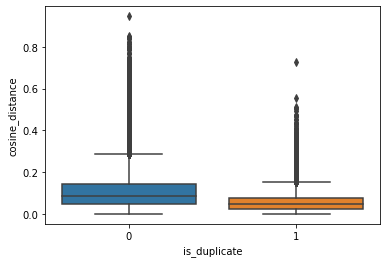

In [23]:
sns.boxplot(x=y_train,y=X_train['cosine_distance'])

###  Cyblock_distance

In [24]:

X_train['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_train),
                                                          np.nan_to_num(tfidf_w2v_question2_train))]


X_cv['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_cv),
                                                          np.nan_to_num(tfidf_w2v_question2_cv))]


X_test['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),
                                                          np.nan_to_num(tfidf_w2v_question2_test))]

<ipython-input-24-4deca1dc6d6d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),


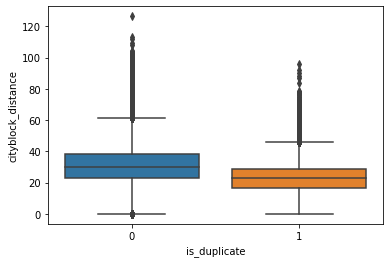

In [25]:
sns.boxplot(x=y_train,y=X_train['cityblock_distance'])

<ipython-input-27-865f0114ce99>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),


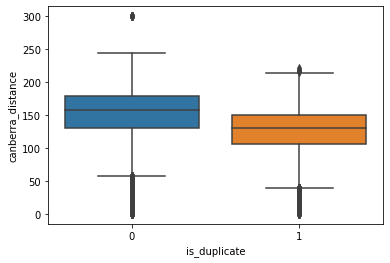

In [27]:

X_train['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_train),
                                                          np.nan_to_num(tfidf_w2v_question2_train))]


X_cv['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_cv),
                                                          np.nan_to_num(tfidf_w2v_question2_cv))]


X_test['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),
                                                          np.nan_to_num(tfidf_w2v_question2_test))]


sns.boxplot(x=y_train,y=X_train['canberra_distance'])

<ipython-input-28-3e72c8c81b86>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),


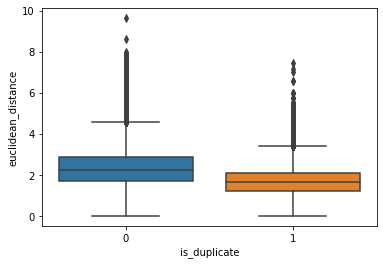

In [28]:
X_train['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_train),
                                                          np.nan_to_num(tfidf_w2v_question2_train))]


X_cv['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_cv),
                                                          np.nan_to_num(tfidf_w2v_question2_cv))]


X_test['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),
                                                          np.nan_to_num(tfidf_w2v_question2_test))]

sns.boxplot(x=y_train,y=X_train['euclidean_distance'])

<ipython-input-29-793889db1b1d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['minkowski_distance'] = [minkowski(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),


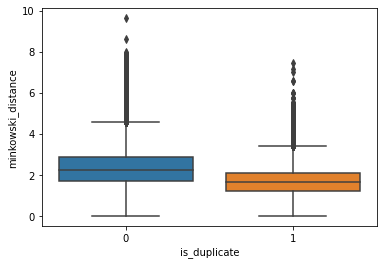

In [29]:
X_train['minkowski_distance'] = [minkowski(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_train),
                                                          np.nan_to_num(tfidf_w2v_question2_train))]


X_cv['minkowski_distance'] = [minkowski(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_cv),
                                                          np.nan_to_num(tfidf_w2v_question2_cv))]


X_test['minkowski_distance'] = [minkowski(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),
                                                          np.nan_to_num(tfidf_w2v_question2_test))]

sns.boxplot(x=y_train,y=X_train['minkowski_distance'])

<ipython-input-30-094ba9a264a3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),


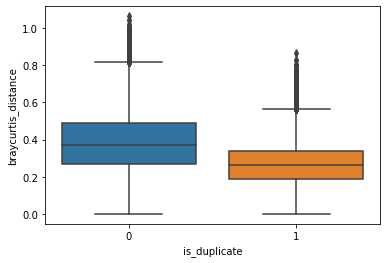

In [30]:
X_train['braycurtis_distance'] = [ braycurtis(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_train),
                                                          np.nan_to_num(tfidf_w2v_question2_train))]


X_cv['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_cv),
                                                          np.nan_to_num(tfidf_w2v_question2_cv))]


X_test['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(tfidf_w2v_question1_test),
                                                          np.nan_to_num(tfidf_w2v_question2_test))]


sns.boxplot(x=y_train,y=X_train['braycurtis_distance'])

In [57]:
X_train.shape

(181476, 39)

In [31]:
#droping not required columns
X_train.drop(['id','qid1','qid2','question1','question2'],inplace=True,axis=1)
X_cv.drop(['id','qid1','qid2','question1','question2'],inplace=True,axis=1)
X_test.drop(['id','qid1','qid2','question1','question2'],inplace=True,axis=1)

C:\Users\rupes\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [61]:
X_train.head(1)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
317179,1,1,48,53,7,9,6,15,0.4,2,...,93,96,0.755102,0.026898,15.911383,1.0,93.429341,1.198627,1.198627,0.166563


In [37]:
# saving target values 
pickle.dump(y_train, open('y_train.pkl', 'wb'), -1)
pickle.dump(y_cv, open('y_cv.pkl', 'wb'), -1)
pickle.dump(y_test, open('y_test.pkl', 'wb'), -1)

In [32]:
from scipy.sparse import hstack
from scipy import sparse

In [33]:
np.array(tfidf_w2v_question1_train).shape

(198091, 300)

In [34]:
X_train.values.shape

(198091, 33)

In [35]:
# joining columns in sparse matrix
X_tr = hstack((sparse.csr_matrix(np.array(tfidf_w2v_question1_train)),\
               sparse.csr_matrix(np.array(tfidf_w2v_question2_train)),\
               sparse.csr_matrix(X_train.values)
               )).tocsr()
X_cr = hstack((sparse.csr_matrix(np.array(tfidf_w2v_question1_cv)),\
               sparse.csr_matrix(np.array(tfidf_w2v_question2_cv)),\
               sparse.csr_matrix(X_cv.values)
               )).tocsr()
X_te = hstack((sparse.csr_matrix(np.array(tfidf_w2v_question1_test)),\
               sparse.csr_matrix(np.array(tfidf_w2v_question2_test)),\
               sparse.csr_matrix(X_test.values)
               )).tocsr()

In [36]:
X_tr=X_tr.todense()
X_cr=X_cr.todense()
X_te=X_te.todense()

### Saving file 

In [41]:
pickle.dump(X_tr, open('X_tr.pkl', 'wb'), -1)
pickle.dump(X_cr, open('X_cr.pkl', 'wb'), -1)
pickle.dump(X_te, open('X_te.pkl', 'wb'), -1)